# Sieci konwolucyjne

Zadanie dla Państwa na te ćwiczenia to implementacja funkcji konwolucji oraz max pooling dla obrazów.

In [1]:
# ploting
# Max Pooling Test
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
# imports
import torch

%matplotlib inline

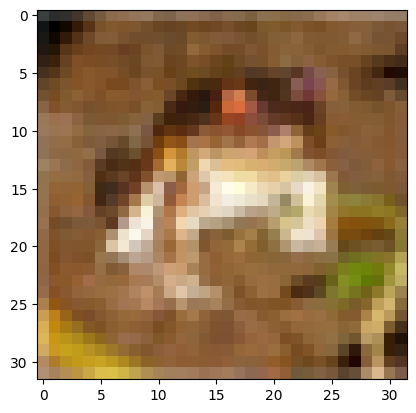

In [2]:
# data loading
cifar_sample = np.load("resources/cifar_sample.npy")
# get a first random image
np_image = cifar_sample[0]
# this should plot a blurry frog
plt.imshow(np_image.transpose(1, 2, 0))

### Wzory na rozmiary
**Pytanie 1**: Jaki będzie rozmiar obrazka na wyjściu konwolucji/poolingu przy parametrach poniżej.  
**Uwaga**: zarówno we wzorach jak i w kodzie używana jest torchowa konwencja *channel first*.

Stride: $ \hspace{95px} S $  
Padding: $ \hspace{80px} P $  
Obrazek wejściowy: $ \hspace{12px} C_i \times H_i \times W_i$  
Filtry: $ \hspace{100px} K \times C_f \times F \times F $  

Gdzie: $C_i$ to liczba kanału obrazu wejściowego, $H_i, W_i$ to odpowiednio wysokość i szerokość obrazu wejściowego. $K$ to liczba filtrów, $C_f$ liczba kanałów w każdym filtrze, $F$ to zarówno wysokość jak i szerokość filtra (rozważamy tylko filtry kwadratowe).

Obrazek wyjściowy: $ \hspace{15px} C_o \times H_o \times W_o $  


$ \hspace{140px} C_o = \text{???} $  

$ \hspace{140px} H_o = \text{???} $  

$ \hspace{140px} W_o = \text{???} $  

**Pytanie 2**: Ile wag (floatów) ma taka warstwa konwolucyja?   


### Wizualna pomoc do konwolucji
[Źródło](http://cs231n.github.io/convolutional-networks/)

<img src="https://raw.githubusercontent.com/gmum/ml2022-23/main/lab/resources/cnn.gif"></img>

### Zadanie 1:  Konwolucja (5 pkt.)
Zadaniem jest zaimplementowanie funkcji konwolucji i poolingu dla obrazka 2D. Implementacja nie musi być optymalna pod względem złożoności czasowej (tzn. można/zaleca się używać pętli). 

Warunkiem zaliczenia zadania jest przejście komórek testowych dla konwolucji i poolingu. W razie problemów polecam zacząć od poolingu, który jest podobny do konwolucji, ale mniej skomplikowany.

In [3]:
import torch.nn.functional as F
def convolution(image: torch.tensor, 
                filters: torch.tensor, 
                bias: torch.tensor, 
                stride: int = 1, 
                padding: int = 1):
    """
    :param image: torch.Tensor 
        Input image of shape (C, H, W)
    :param filters: torch.Tensor 
        Filters to use in convolution of shape (K, C, F, F)
    :param bias: torch.Tensor 
        Bias vector of shape (K,)
    :param stride: int
        Stride to use in convolution
    :param padding: int
       Zero-padding to add on all sides of the image 
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape 
    n_filters, filter_channels, filter_size, filter_size = filters.shape 
    # calculate the dimensions of the output image
    padd_img = F.pad(image, (padding, padding, padding, padding))
    out_height = (img_height + 2 * padding - filter_size) // stride + 1
    out_width = (img_width + 2 * padding - filter_size) // stride + 1
    out_channels = img_channels
    output = torch.zeros((n_filters, out_height, out_width))
    
    for k in range(n_filters):
        for i in range(0, out_height):
            for j in range(0, out_width):
                region = padd_img[:,
                                  i*stride:i*stride+filter_size,
                                  j*stride:j*stride+filter_size]
                output[k, i, j] = torch.sum(region * filters[k]) + bias[k]


    # your code here
                
    return output

In [4]:
# Convolution Test

# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
paddings = [0, 1, 2, 3]
strides = [1, 2, 3, 4]
filters = [
    (torch.randn((2, 3, 3, 3)), torch.randn((2))),
    (torch.randn((2, 3, 5, 5)), torch.randn((2))),
    (torch.randn((5, 3, 1, 1)), torch.randn((5))),
]

# test all combinations
for (filt, bias), stride, padding in product(filters, strides, paddings):
    # your convolution
    out = convolution(image, filt, bias, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.conv2d(
        input=image.unsqueeze(0), weight=filt, bias=bias, padding=padding, stride=stride
    )
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

### Zadanie 2. Max Pooling (2 pkt.)
Operacja *max pooling* jest analogiczna do zwykłej konwolucji, lecz zamiast operacji mnożenia z zadanym filtrem na każdym fragmencie wejścia wykonywana jest funkcja *max*.

In [5]:
def max_pooling(image: torch.tensor, 
                kernel_size: int, 
                stride: int = 1, 
                padding: int = 1):
    """
    :param image: torch.Tensor 
        Input image of shape (C, H, W)
    :param kernel_size: int 
        Size of the square pooling kernel
    :param stride: int
        Stride to use in pooling
    :param padding: int
       Zero-padding to add on all sides of the image 
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape
    # calculate the dimensions of the output image
    out_height = (img_height + 2 * padding - kernel_size) // stride + 1
    out_width = (img_width + 2 * padding - kernel_size) // stride + 1
    out_channels = img_channels
    padd_img = F.pad(image, (padding, padding, padding, padding))
    pool_out = torch.zeros((img_channels, out_height, out_width))


    for c in range(img_channels):
        for i in range(out_height):
            for j in range(out_width):
                region = padd_img[c,
                                  i*stride:i*stride+kernel_size,
                                  j*stride:j*stride+kernel_size]
                pool_out[c, i, j] = torch.max(region)
    # your code here

    return pool_out

In [6]:
# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
kernel_sizes = [2, 3, 4]
paddings = [0, 1]
strides = [1, 2, 3, 4]

# test all combinations
for kernel_size, stride, padding in product(kernel_sizes, strides, paddings):
    # your pooling
    out = max_pooling(image, kernel_size=kernel_size, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.nn.functional.max_pool2d(
        input=image.unsqueeze(0), kernel_size=kernel_size, padding=padding, stride=stride
    )
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

# Trenowanie sieci kowolucyjnych

**Uwaga:** Poniższa część notebooka jest stworzona z myślą o uruchamianiu go w [Colaboratory](https://colab.research.google.com/) (link do przeglądania repozytoriów w colabie: [link](https://colab.research.google.com/github/)), oznacza to, że przygotowane zadania zakładają uczenie modelu z użyciem GPU. Na zajęciach zostanie krótko omówione używanie Colaboratory. Na własną odpowiedzialność można używać własnego komputera do rozwiązania pracy domowej.

In [5]:
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import (RandomVerticalFlip, ToTensor)

### CIFAR10
[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 $\times$ 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje.

Files already downloaded and verified
CIFAR10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


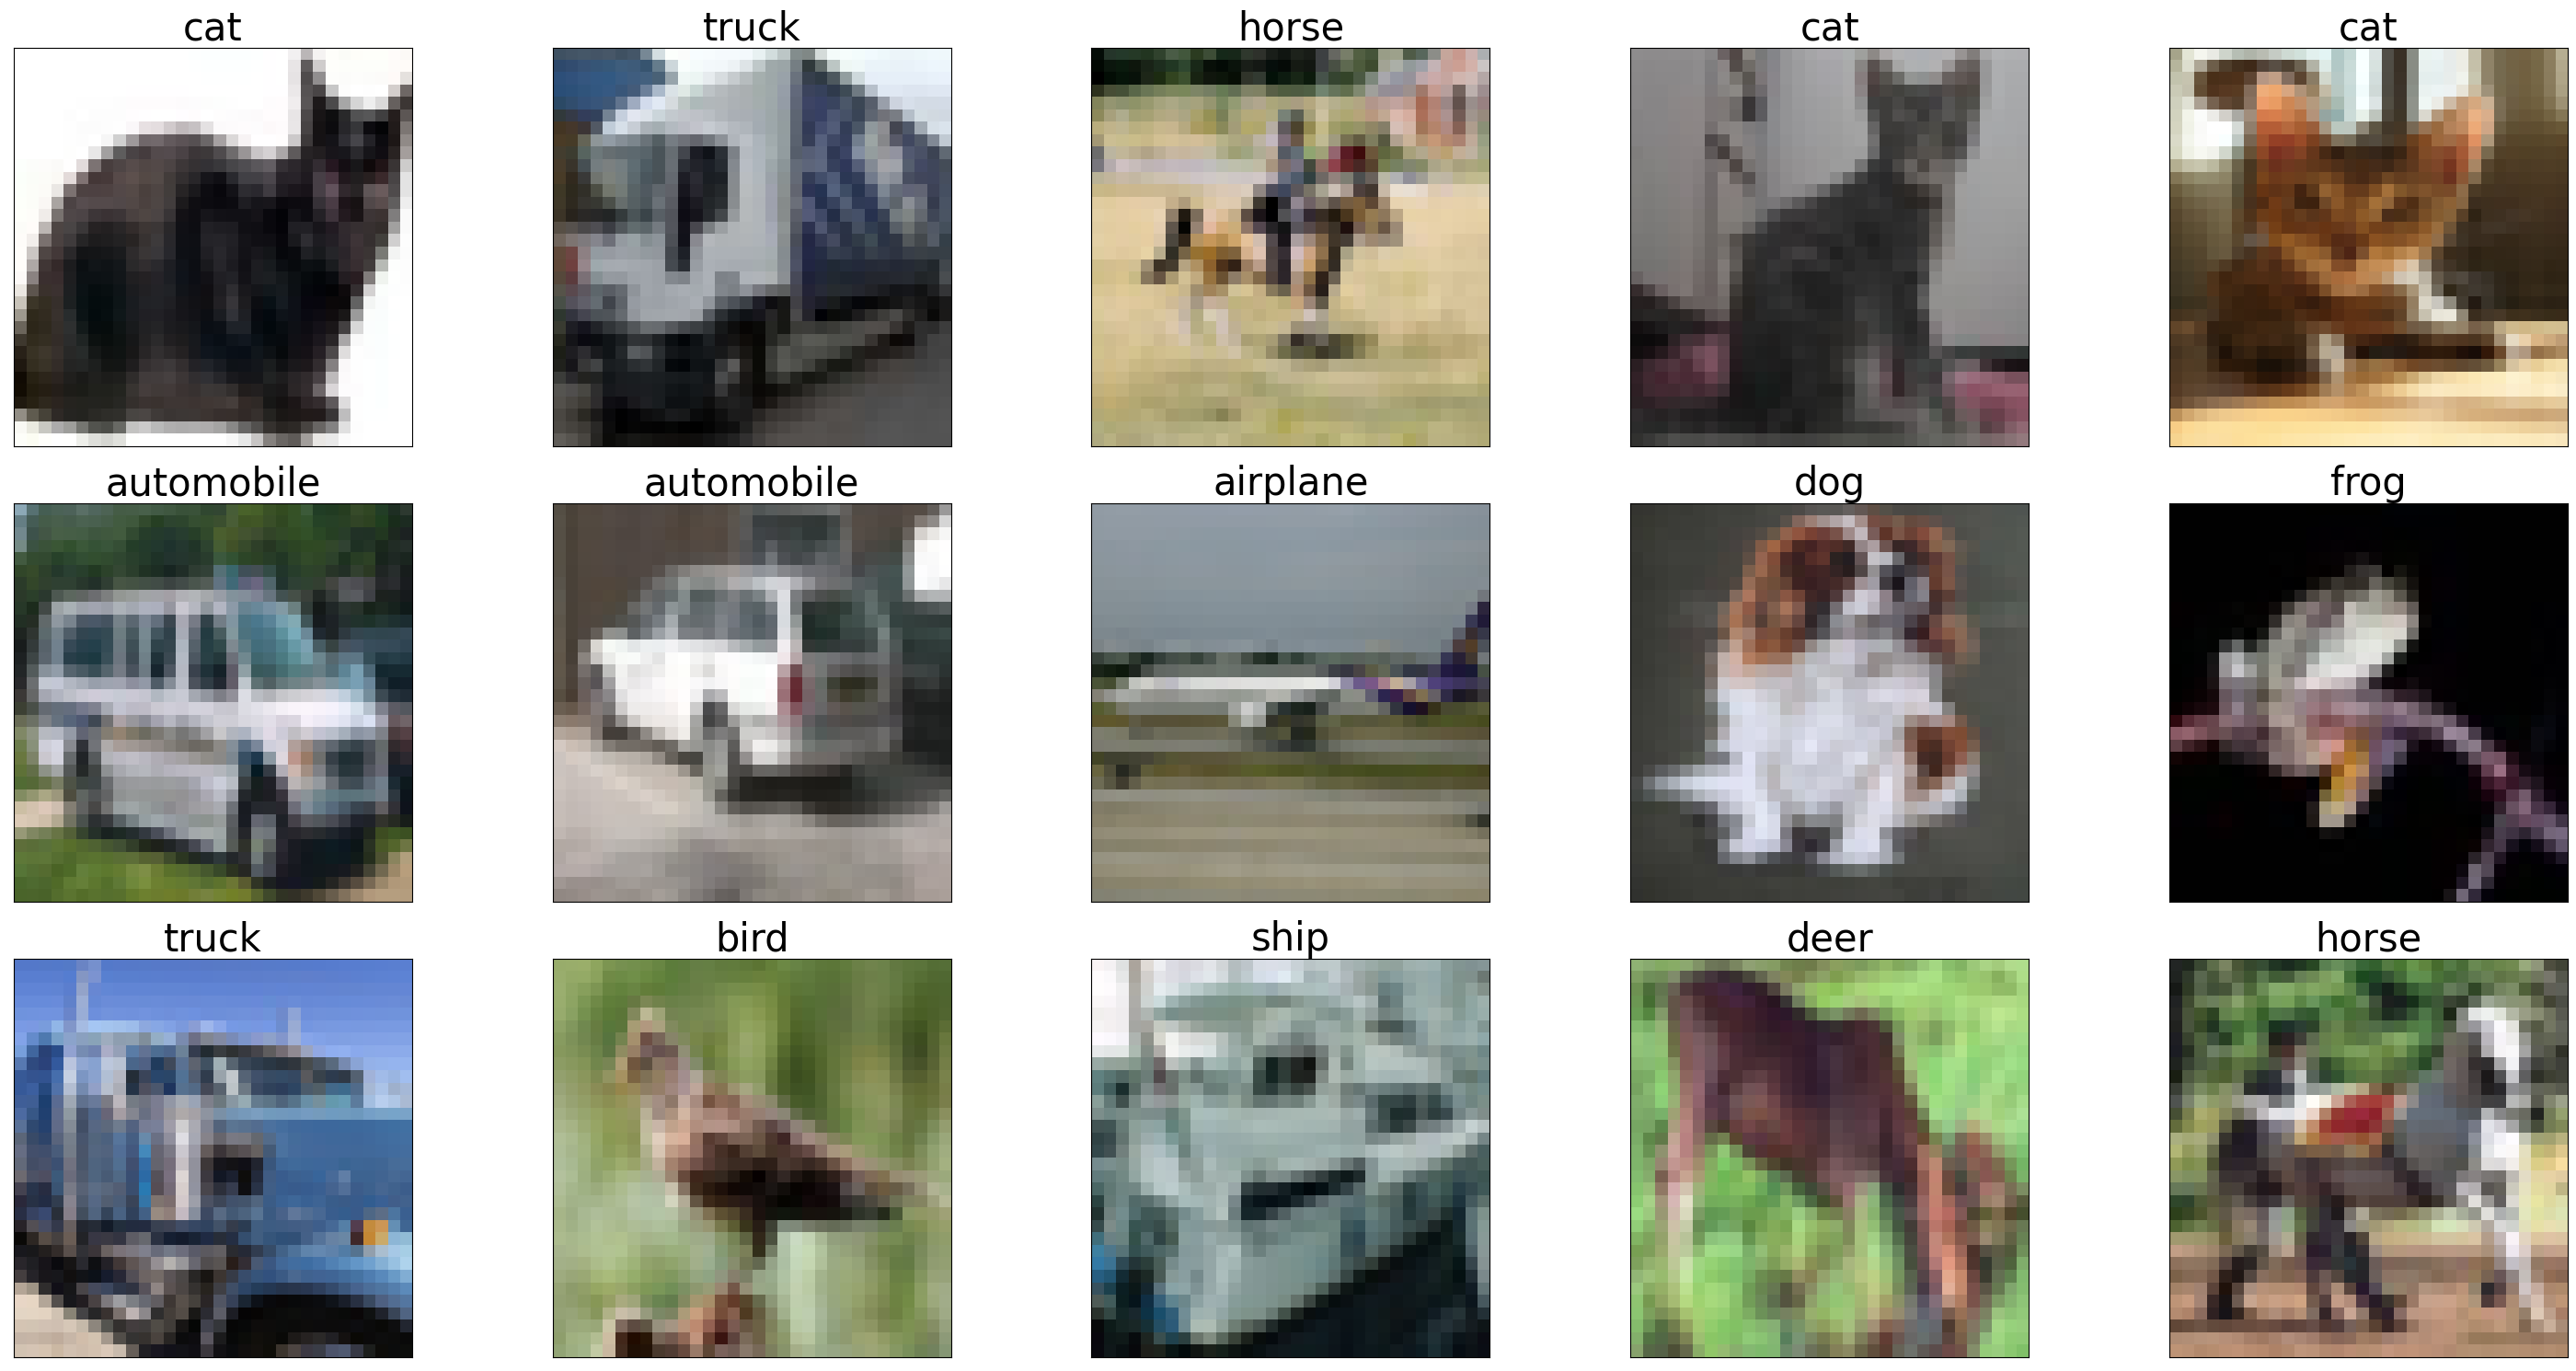

In [8]:
dataset = CIFAR10(root=".", train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

# prepare visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={"size": 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")

### Zadanie 3. Sieć Konwolucyjna na CIFAR10 (4 pkt.)

Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować *loss* w trakcie trenowania, testowania oraz *accuracy* na zbiorze testowym (opcjonalnie również na treningowym). Na koniec *accuracy* powinno osiągnąć wynik powyżej 75% na zbiorze testowym. Można korzystać z dowolnych mechanizmów dostępnych w PyTorchu.

Porady do zadania:

* Zwiększenie treningowego *batch size* może przyspieszyć uczenie, ale należy pamiętać, że, tak jak każdy hiperparametr, *batch_size* ma wpływ na proces uczenia.
* Przy dobieraniu architektury bądź hiperparametrów nie testować dłużej niż kilka epok (około 5), tak aby mieć szybki feedback. Dopiero po dobraniu powyższych rzeczy puścić dłuższe uczenie. Warto przy okazji wizualizować krzywe uczenia (funkcji kosztu) aby zwrócić uwagę na to kiedy koszt zaczyna się "wypłaszczać" i czy model przypadkowo nie overfituje (patrząc na wartości kosztu na zbiorze testowym)
* Dodatkowe (nadobowiązkowe) rzeczy do poprawienia wyniku: LR Schedule, Early Stopping.

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torch.nn.functional as F


In [72]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)
        x = F.relu(self.bn6(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

In [73]:
train_data = CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
test_data = CIFAR10(root='./data', train=False, download=True, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [74]:
batch_size = 256
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [75]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [76]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)


In [77]:
def evaluate(model, loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return running_loss / len(loader), accuracy


In [78]:
epochs = 20
for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    scheduler.step()  # Adjust learning rate
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

print("Lol")

Epoch [1/20], Train Loss: 1.2432, Test Loss: 1.0954, Test Accuracy: 61.33%
Epoch [2/20], Train Loss: 0.8553, Test Loss: 0.9953, Test Accuracy: 65.54%
Epoch [3/20], Train Loss: 0.6919, Test Loss: 1.1695, Test Accuracy: 62.41%
Epoch [4/20], Train Loss: 0.5739, Test Loss: 0.9255, Test Accuracy: 69.34%
Epoch [5/20], Train Loss: 0.4777, Test Loss: 0.9471, Test Accuracy: 68.94%
Epoch [6/20], Train Loss: 0.3035, Test Loss: 0.7547, Test Accuracy: 76.56%
Epoch [7/20], Train Loss: 0.2224, Test Loss: 0.8102, Test Accuracy: 75.70%
Epoch [8/20], Train Loss: 0.1726, Test Loss: 0.8349, Test Accuracy: 76.08%
Epoch [9/20], Train Loss: 0.1355, Test Loss: 0.8796, Test Accuracy: 76.57%
Epoch [10/20], Train Loss: 0.1133, Test Loss: 0.9346, Test Accuracy: 76.89%
Epoch [11/20], Train Loss: 0.0505, Test Loss: 0.8509, Test Accuracy: 78.91%
Epoch [12/20], Train Loss: 0.0236, Test Loss: 0.8973, Test Accuracy: 78.87%
Epoch [13/20], Train Loss: 0.0178, Test Loss: 0.9010, Test Accuracy: 79.14%
Epoch [14/20], Train 

### Zadanie 4. Augmentacja danych (1 pkt.)

Używając funkcjonalności dostępnych w [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) dodaj augmentacje danych do datasetu treningowego, zobacz o ile poprawia to wynik twojego modelu z poprzedniego zadania. W razie wątpliwości najlepiej przeszukać internet w poszukiwaniu typowych augmentacji dla CIFAR10.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Normalize, Compose, RandomHorizontalFlip, RandomCrop, RandomRotation


In [67]:
# tutaj dodaj wybrane augumentcje danych treningowych i załaduj testowe

from torchvision.transforms import RandomResizedCrop, ColorJitter, RandomAffine

train_transform = Compose([
    RandomResizedCrop(32, scale=(0.8, 1.0)),   # Randomly crop and resize
    RandomHorizontalFlip(),
    RandomRotation(15),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Change colors slightly
    RandomAffine(10),  # Small rotations and translations
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=train_transform)

test_dataset = CIFAR10(root='.', 
                       train=False, 
                       download=True,
                       transform=test_transform)


train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [68]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [69]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)


In [70]:
def evaluate(model, loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return running_loss / len(loader), accuracy

In [71]:
epochs = 20
for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    scheduler.step()  # Adjust learning rate
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

print("Lol z transforms")

Epoch [1/20], Train Loss: 1.5101, Test Loss: 1.2107, Test Accuracy: 57.08%
Epoch [2/20], Train Loss: 1.1921, Test Loss: 1.0585, Test Accuracy: 63.26%
Epoch [3/20], Train Loss: 1.0651, Test Loss: 0.9284, Test Accuracy: 67.02%
Epoch [4/20], Train Loss: 0.9856, Test Loss: 0.8492, Test Accuracy: 70.89%
Epoch [5/20], Train Loss: 0.9284, Test Loss: 0.9064, Test Accuracy: 69.65%
Epoch [6/20], Train Loss: 0.8373, Test Loss: 0.7155, Test Accuracy: 75.49%
Epoch [7/20], Train Loss: 0.8016, Test Loss: 0.7024, Test Accuracy: 75.96%
Epoch [8/20], Train Loss: 0.7778, Test Loss: 0.7027, Test Accuracy: 75.77%
Epoch [9/20], Train Loss: 0.7594, Test Loss: 0.6369, Test Accuracy: 77.72%
Epoch [10/20], Train Loss: 0.7448, Test Loss: 0.6159, Test Accuracy: 78.92%
Epoch [11/20], Train Loss: 0.6945, Test Loss: 0.5879, Test Accuracy: 79.52%
Epoch [12/20], Train Loss: 0.6682, Test Loss: 0.5929, Test Accuracy: 79.60%
Epoch [13/20], Train Loss: 0.6601, Test Loss: 0.5716, Test Accuracy: 80.49%
Epoch [14/20], Train 